# Описание
Здесь представлен baseline для [соревнования](https://stepik.org/lesson/226979/step/1?unit=199528), 
который дается в конце курса ["Введение в Data Science и машинное обучение"](https://stepik.org/course/4852/) на stepic.

За основу взять признаки которые создавали в течении курса. ROC_AUC = 0.8792.

# Импорт

In [101]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.externals import joblib

import libs.data_helpers as dh
import libs.data_iter1 as di
import libs.utils.model_utils as mu
import libs.submit_report as rep

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from xgboost import XGBClassifier

seed = 496

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Загрузка и подготовка данных

In [2]:
# загрузка данных
events  = pd.read_csv("./data/event_data_train.zip")
submissions = pd.read_csv("./data/submissions_data_train.zip")

# разделение данных для обучения на train и test
_ = dh.split_events_submissions(events, submissions, test_size=0.3)
events_train_orig, events_test_orig, submissions_train_orig, submissions_test_orig = _

# подготовка данных
X_train, y_train = di.get_x_y(events_train_orig, submissions_train_orig)
X_test, y_test = di.get_x_y(events_test_orig, submissions_test_orig)

E:\Python\stepik_course_4852_contest\libs\data_helpers.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['date'] = pd.to_datetime(data.timestamp, unit='s')
E:\Python\stepik_course_4852_contest\libs\data_helpers.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['day'] = data.date.dt.date


In [3]:
X_train['correct_ratio'] = X_train.correct / (X_train.correct + X_train.wrong)
X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)
#X_train.correct_ratio.fillna(0,inplace=True)
#X_test.correct_ratio.fillna(0,inplace=True)

In [86]:
X_train['diff_discoverd_passed'] = (X_train.discovered - X_train.passed) / X_train.day
X_test['diff_discoverd_passed'] = (X_test.discovered - X_test.passed) / X_test.day

# fillna ?

# add one more metric - tasks pro day?

In [87]:
# wrong ratio

In [88]:
# binary features + encoding

In [ ]:
# filter the data by outliers?

In [ ]:
# correlation

In [89]:
X_train.head()

,correct,wrong,discovered,passed,started_attempt,viewed,day,correct_ratio,diff_discoverd_passed
user_id,,,,,,,,,
2,2.0,0.0,9,9,2,9,1,1.000000,0.0
5,2.0,2.0,1,1,0,1,1,0.500000,0.0
8,9.0,21.0,109,84,37,154,1,0.300000,25.0
14,0.0,1.0,4,3,1,9,1,0.000000,1.0
16,18.0,23.0,50,49,21,117,2,0.439024,0.5


In [114]:
# normalise the data with gaps fill using sklearn
df_num_features = X_train.columns.copy()
#df_num_features

num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='median',copy = False)), # with median a little bit better
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, df_num_features)
    ]
)

In [115]:
baseline_transform = Pipeline(
    steps=[
        ('preprocessing', preprocessor)
    ]
)

In [131]:
X_train_p = baseline_transform.fit_transform(X_train)
X_test_p = baseline_transform.transform(X_test)

# Обучение и проверка модели

NEural network use

## RandomForest

In [134]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            min_samples_leaf=10, min_samples_split=10, 
                            class_weight='balanced', random_state = seed)

rf.fit(X_train_p, y_train)
pred_proba = rf.predict_proba(X_test_p)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)
# должны получить roc 0.92  +- 0.02

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=496,
            verbose=0, warm_start=False)

roc на test 0.9231402451671783


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic example')

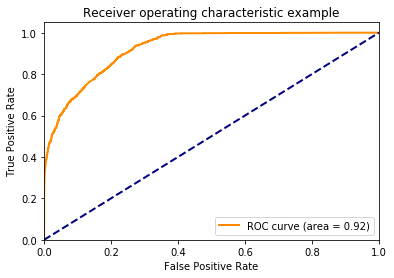

In [135]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [137]:
# важность фич
fimp = mu.get_feature_importances_df(rf.feature_importances_, X_train.columns)
fimp.head(15)

,weight
correct_ratio,0.280960
correct,0.279311
passed,0.160080
discovered,0.094628
viewed,0.073268
started_attempt,0.047426
wrong,0.042231
diff_discoverd_passed,0.012657
day,0.009439


## кроссвалидация

In [138]:
# значение к метрике на кроссвалидации коррелирует к метрике на степике

rfcv = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(rfcv, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.9247366417611914


## Сохранение модели

In [8]:
# Расскоментируйте, если нужно сохранить модель
# !mkdir ./bin_models
# joblib.dump(rf, './bin_models/baseline_random_forest.bin')

# код для загрузки модели
# rf = joblib.load('./bin_models/baseline_random_forest.bin')

### SVC

In [27]:
svc = SVC(kernel = 'linear',
          gamma = 'scale',
          C = 1, #наилучший С был получен в одной из попыток, похоже классификатор не очень хорошо может задать разделяющую плоскость. 
          random_state = seed,          
          decision_function_shape = 'ovr',                             
          class_weight = 'balanced',     
          probability = True)

svc.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=496, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
pred_proba = svc.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9147754157419316


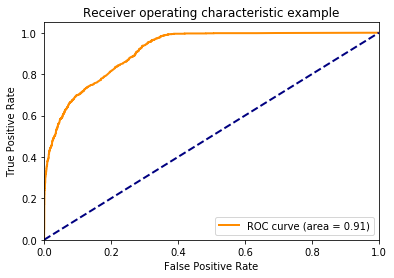

In [29]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

In [41]:
my_scorer = make_scorer(roc_auc_score)
skv = StratifiedKFold(n_splits = 5,random_state=seed, shuffle=True)

param_grid = {
    'C': [0.01, 0.1, 0.3, 0.5, 0.8, 1.5, 5, 10],
    'kernel': ['linear', 'rbf', 'poly']
}


bclf = GridSearchCV(svc, param_grid,
                   scoring=my_scorer, cv=skv, verbose=9, n_jobs=-1,refit='roc_auc')

In [42]:
bclf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 61.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=496, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=496, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 0.3, 0.5, 0.8, 1.5, 5, 10], 'kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=9)

In [46]:
bclf.best_params_
best_clf = bclf.best_estimator_

{'C': 10, 'kernel': 'rbf'}

In [47]:
pred_proba = best_clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9143986617698912


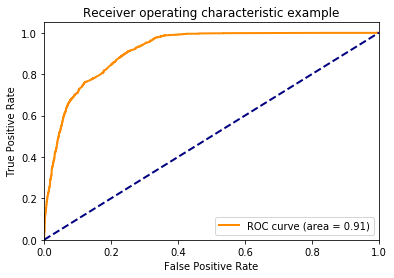

In [48]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

In [49]:
SUBMIT_NUM = 2

events_pred  = pd.read_csv("./data/events_data_test.zip")
submissions_pred = pd.read_csv("./data/submission_data_test.zip")
X_pred , _ = di.get_x_y(events_pred, submissions_pred)

X_pred['correct_ratio'] = X_pred.correct / (X_pred.correct + X_pred.wrong)
X_pred.correct_ratio.fillna(0,inplace=True)

In [50]:
pred_proba = bclf.predict_proba(X_pred)[:, 1]
rep_df = rep.create_report(X_pred.index, pred_proba)
assert rep_df.user_id.nunique() == X_pred.index.nunique()
print ('Прогноз сохранен в файл ', rep.save_report(rep_df, SUBMIT_NUM))

print ('Распределение "вероятностей" модели')
pd.cut(pred_proba, 10).value_counts()

Прогноз сохранен в файл  ./reports/predict_2019-06-01_submit_2.csv
Распределение "вероятностей" модели


(-0.000786, 0.0994]    3683
(0.0994, 0.199]         316
(0.199, 0.298]          218
(0.298, 0.397]          277
(0.397, 0.496]          342
(0.496, 0.596]          274
(0.596, 0.695]          718
(0.695, 0.794]          199
(0.794, 0.893]          112
(0.893, 0.992]           45
dtype: int64

### XGBoost.

In [71]:
params={
    'n_estimators':400,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':4,
    'max_depth':5,
    'seed':seed,
    'eval_metric':'auc',
    
    }

xbg_clf = XGBClassifier(**params)

In [72]:
xbg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, eval_metric='auc', gamma=0.1,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=496,
       silent=True, subsample=0.8)

In [73]:
pred_proba = xbg_clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.92584469050755


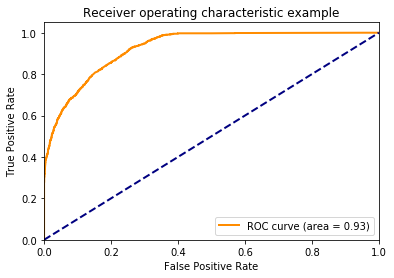

In [74]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

In [75]:
cv_scores = cross_val_score(xbg_clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.9247227295197922


In [76]:
SUBMIT_NUM = 3

events_pred  = pd.read_csv("./data/events_data_test.zip")
submissions_pred = pd.read_csv("./data/submission_data_test.zip")
X_pred , _ = di.get_x_y(events_pred, submissions_pred)

X_pred['correct_ratio'] = X_pred.correct / (X_pred.correct + X_pred.wrong)
X_pred.correct_ratio.fillna(0,inplace=True)

In [77]:
pred_proba = xbg_clf.predict_proba(X_pred)[:, 1]
rep_df = rep.create_report(X_pred.index, pred_proba)
assert rep_df.user_id.nunique() == X_pred.index.nunique()
print ('Прогноз сохранен в файл ', rep.save_report(rep_df, SUBMIT_NUM))

print ('Распределение "вероятностей" модели')
pd.cut(pred_proba, 10).value_counts()

Прогноз сохранен в файл  ./reports/predict_2019-06-01_submit_3.csv
Распределение "вероятностей" модели


(-0.000707, 0.1]    3515
(0.1, 0.2]           361
(0.2, 0.3]           740
(0.3, 0.4]           301
(0.4, 0.5]           240
(0.5, 0.6]           165
(0.6, 0.7]           157
(0.7, 0.8]            96
(0.8, 0.9]           106
(0.9, 1.0]           503
dtype: int64

# Сделать предсказание по сабмиту

In [9]:
SUBMIT_NUM = 3

events_pred  = pd.read_csv("./data/events_data_test.zip")
submissions_pred = pd.read_csv("./data/submission_data_test.zip")
X_pred , _ = di.get_x_y(events_pred, submissions_pred)

X_pred['correct_ratio'] = X_pred.correct / (X_pred.correct + X_pred.wrong)
X_pred.correct_ratio.fillna(0,inplace=True)

In [10]:
pred_proba = rf.predict_proba(X_pred)[:, 1]
rep_df = rep.create_report(X_pred.index, pred_proba)
assert rep_df.user_id.nunique() == X_pred.index.nunique()
print ('Прогноз сохранен в файл ', rep.save_report(rep_df, SUBMIT_NUM))

print ('Распределение "вероятностей" модели')
pd.cut(pred_proba, 10).value_counts()

Прогноз сохранен в файл  ./reports/predict_2019-05-31_submit_1.csv
Распределение "вероятностей" модели


(-0.000647, 0.1]    3342
(0.1, 0.2]           129
(0.2, 0.3]           117
(0.3, 0.4]           169
(0.4, 0.5]           434
(0.5, 0.6]           577
(0.6, 0.7]           313
(0.7, 0.8]           252
(0.8, 0.9]           266
(0.9, 1.0]           585
dtype: int64